# Experiment Setup 2: Fast Text Word Embedding
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
This experiment aims to use Fast Text word embedding on the base LSTM model and gauge how it improves its performance.

#### Import Modules

In [58]:
import pickle
import pandas as pd
import numpy as np
import keras
import h5py
import nltk
from functools import lru_cache
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [59]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_WORD = 150

BATCH_SIZE = 128
EPOCHS = 5

#### Functions

In [60]:
def pickle_dataset(filename, dataset):
    file = open("{0}.pickle".format(filename),"wb")
    pickle.dump(dataset, file)
    file.close()

In [61]:
def round_pred(predictions):
    y_pred = [prediction.round() for prediction in predictions]
    
    return y_pred

In [62]:
def gen_confusion_matrix(y_true,y_pred):
    confusion_matrices={}

    for label_col in range(len(LABEL_FIELDS)):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]
        confusion_matrices[LABEL_FIELDS[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
    return confusion_matrices

In [63]:
def plot_precision_recall_curve(y_test,y_pred):
    # precision recall curve
    precision = dict()
    recall = dict()

    for i in range(len(LABEL_FIELDS)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

In [64]:
def plot_roc_curve(y_test, y_pred):
    # roc curve
    fpr = dict()
    tpr = dict()

    for i in range(len(LABEL_FIELDS)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                      y_pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()

In [65]:
def build_model(optimiser="adam"):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 100, input_length=150))
    model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

    return model


#### Read in preprocessed test and train datasets

In [76]:
train = pickle.load(open("balanced_train.pickle", "rb"))
test = pickle.load(open("balanced_test.pickle", "rb"))

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

y_train = pickle.load(open("balanced_train_labels.pickle", "rb"))

x_sequences_test = tokenizer.texts_to_sequences(test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

y_test = pickle.load(open("balanced_test_labels.pickle", "rb"))
y_test = np.asarray(y_test)

In [77]:
print(x_padded_train.shape)
print(y_train.shape)
print(x_padded_test.shape)
print(y_test.shape)

(78598, 150)
(78598, 6)
(10875, 150)
(10875, 6)


#### Fasttext
Use the large collection of Wikipedia articles to create word vectors to be used in the LSTM model

In [78]:
index = {}

file = open('./wiki-news-300d-1M.vec', encoding='utf8')
for line in file:
    values = line.split()
    word = values[0]
    index[word] = np.asarray(values[1:], dtype='float32')
file.close()

fasttext = np.random.random((len(corpus) + 1, EMBEDDING_DIM))
for word, i in corpus.items():
    embedding_vector = index.get(word)
    if embedding_vector is not None:
        fasttext[i] = embedding_vector

#### Define LSTM model
Code influenced by https://stackabuse.com/python-for-nlp-working-with-facebook-fasttext-library/

In [79]:
modelWE = Sequential()
modelWE.add(Embedding(len(corpus) + 1,
                       EMBEDDING_DIM,
                       weights = [fasttext],
                       input_length = MAX_WORD,
                       trainable=False))
modelWE.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
modelWE.add(GlobalMaxPooling1D())
modelWE.add(Dropout(0.5))
modelWE.add(Dense(30, activation='relu'))
modelWE.add(Dropout(0.5))
modelWE.add(Dense(6, activation='sigmoid'))

modelWE.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history = modelWE.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
553/553 [==============================] - 584s 1s/step - loss: 0.1948 - accuracy: 0.4575 - val_loss: 0.0522 - val_accuracy: 0.9952
Epoch 2/5
553/553 [==============================] - 590s 1s/step - loss: 0.0929 - accuracy: 0.8734 - val_loss: 0.0482 - val_accuracy: 0.9952
Epoch 3/5
553/553 [==============================] - 643s 1s/step - loss: 0.0842 - accuracy: 0.9559 - val_loss: 0.0467 - val_accuracy: 0.9952
Epoch 4/5
553/553 [==============================] - 624s 1s/step - loss: 0.0804 - accuracy: 0.9757 - val_loss: 0.0458 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 595s 1s/step - loss: 0.0779 - accuracy: 0.9841 - val_loss: 0.0455 - val_accuracy: 0.9952


In [81]:
modelWE.save('fasttext_model')

INFO:tensorflow:Assets written to: fasttext_model\assets


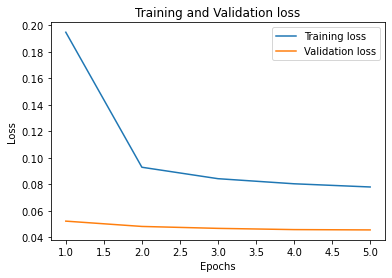

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

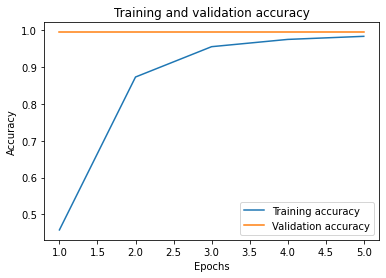

In [83]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [84]:
pred = modelTL.predict(x_padded_test)

In [85]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


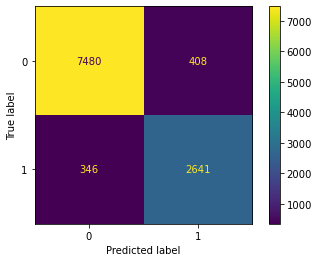

In [86]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


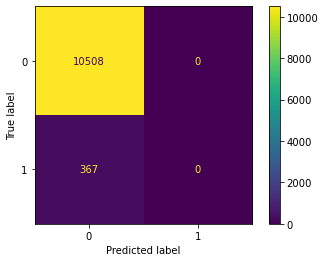

In [87]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


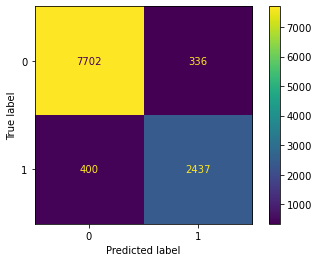

In [88]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


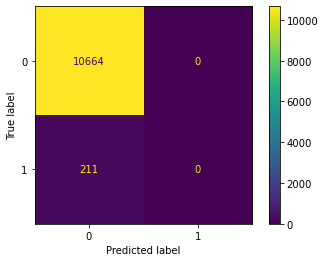

In [89]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


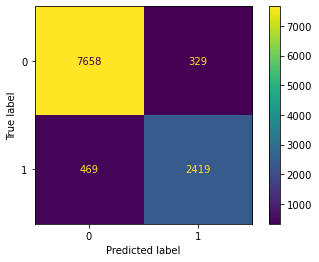

In [90]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


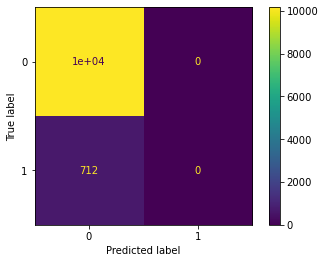

In [91]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

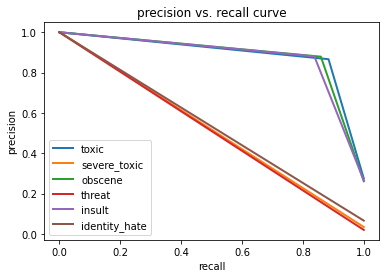

In [92]:
plot_precision_recall_curve(y_test,y_pred)

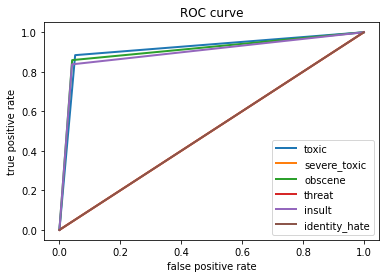

In [93]:
plot_roc_curve(y_test,y_pred)

In [94]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      2987
           1       0.00      0.00      0.00       367
           2       0.88      0.86      0.87      2837
           3       0.00      0.00      0.00       211
           4       0.88      0.84      0.86      2888
           5       0.00      0.00      0.00       712

   micro avg       0.87      0.75      0.81     10002
   macro avg       0.44      0.43      0.43     10002
weighted avg       0.76      0.75      0.76     10002
 samples avg       0.24      0.21      0.22     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Discussion
The word embedding setup has improved upon the base model. From the confusion matrices and classification report of the labels the base model can generalise, it is evident that the word embeddings have improved on the precision and recall of the predictions. An unofficial experiment was done to implement K Fold cross validation with word embeddings to get the model to generalise the 3 labels with the poorest results. However, the model was still unable to correctly predict these 3 labels, giving an indication that the model is underfitted for those 3 labels. Overall, for the labels the model was able to generalise, the performance is relatively high, showing that the word embeddings were able to provide more information to the base LSTM model.